In [1]:
import h5py
import torch
import torch.nn as nn


import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import config

from torch.utils.data import DataLoader, TensorDataset


/home/thien/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
# rows from DeepMIMO dataset settings
# change rows according to the .mat dataset file 
rows = [['550', '568']] # , ['5100','5109']

In [4]:
#load .mat file
[H_true_train, H_true_val], [H_equal_train, H_linear_train, H_practical_train], [H_equal_val, H_linear_val, H_practical_val] = utils.load_data(config.outer_file_path, rows, config.device, config.SNR)
# trainLabels: true channels for training
# valLabels: true channels for validating (testing)

# equal: LS
# linear: LS+linear interpolation
# practical: Matlab practical estimation


In [5]:
# Normalization
H_linear_train_min = H_linear_train.min()
H_linear_train_max = H_linear_train.max()
H_true_train_min = H_true_train.min()
H_true_train_max = H_true_train.max()

H_linear_train_normd = (H_linear_train - H_linear_train_min)/ (H_linear_train_max - H_linear_train_min)
H_true_train_nomrd   = (H_true_train - H_true_train_min)/ (H_true_train_max - H_true_train_min)

H_linear_val_normd   = (H_linear_val - H_linear_train_min)/ (H_linear_train_max - H_linear_train_min)
H_true_val_normd     = (H_true_val - H_true_train_min)/ (H_true_train_max - H_true_train_min)
# for evaluation, output of model(valData) will be de-normalized and compared with valLabels

print(H_linear_val_normd.shape)
print(H_linear_train_normd.shape)

torch.Size([367, 2, 612, 14])
torch.Size([3072, 2, 612, 14])


In [6]:
# Doppler_phase = exp(-1j*2*pi*params.carrier_freq*( ((path_params.Doppler_vel.*delay)./physconst('LightSpeed')) + ((path_params.Doppler_acc.*(delay.^2))./(2*physconst('LightSpeed'))) ));

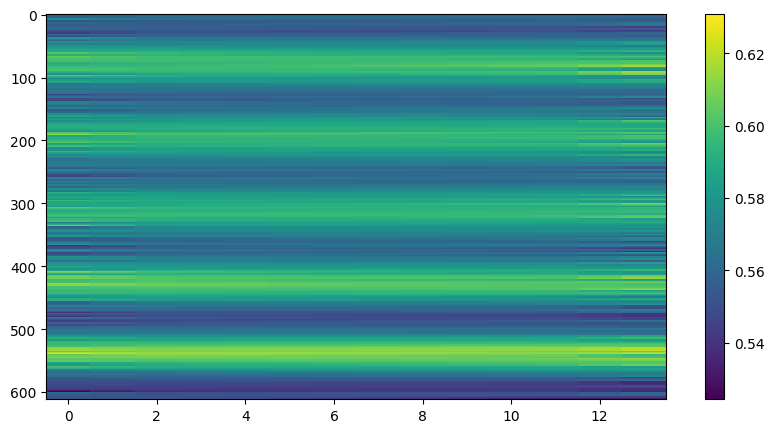

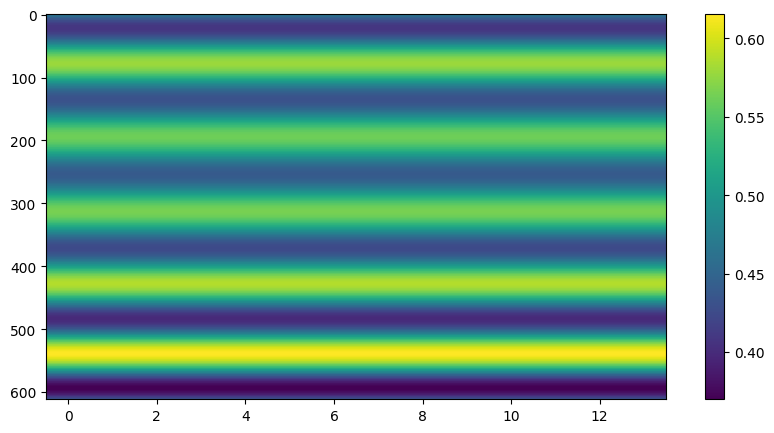

In [7]:
plot = 1
if plot:
    H_temp = H_linear_train_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

    H_temp = H_true_train_nomrd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

In [8]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((H_linear_train_normd[:,0,:,:], H_linear_train_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels_normd = torch.cat((H_true_train_nomrd[:,0,:,:], H_true_train_nomrd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)

trainData_normd.shape

torch.Size([6144, 1, 612, 14])

In [9]:
# Create a DataLoader for your dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [6144, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(H_linear_val_normd, H_true_val_normd)  # [367, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [32]:
H_linear_val_normd.shape

torch.Size([6144, 1, 612, 14])

In [34]:
H_true_val_normd.shape

torch.Size([367, 2, 612, 14])

In [10]:
model = utils.CNN_Est().to(config.device)
print(model)

CNN_Est(
  (normalization): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [11]:
train_loss, vali_loss, H_NN_val = config.train_loop(config.learning_rate, H_true_val, val_loader, train_loader, model, config.NUM_EPOCHS)

Epoch 1/20, Loss: 0.028356123473713524 
 Val Loss: 0.0011876126203181532
Epoch 2/20, Loss: 0.0006275449688170435 
 Val Loss: 0.0006089880965494862
Epoch 3/20, Loss: 0.00033233511256488174 
 Val Loss: 0.00026876857070116483
Epoch 4/20, Loss: 0.0002761825166999188 
 Val Loss: 0.00022826869098935276
Epoch 5/20, Loss: 0.00025948422959724365 
 Val Loss: 0.00030653000915966305
Epoch 6/20, Loss: 0.0002436766504085123 
 Val Loss: 0.00018753454666390704
Epoch 7/20, Loss: 0.00022927050448136774 
 Val Loss: 0.00019776751469180454
Epoch 8/20, Loss: 0.00022874268256600772 
 Val Loss: 0.0001751431033577925
Epoch 9/20, Loss: 0.00020611376203305554 
 Val Loss: 0.00016952788761651996
Epoch 10/20, Loss: 0.00020594547663677076 
 Val Loss: 0.0004614450917870272
Epoch 11/20, Loss: 0.00021954219569882602 
 Val Loss: 0.00026098114297686453
Epoch 12/20, Loss: 0.00020030968842850902 
 Val Loss: 0.00022153444842842873
Epoch 13/20, Loss: 0.00019366626872852066 
 Val Loss: 0.00016452294282013705
Epoch 14/20, Loss

In [12]:
H_NN_val.shape

torch.Size([367, 2, 612, 14])

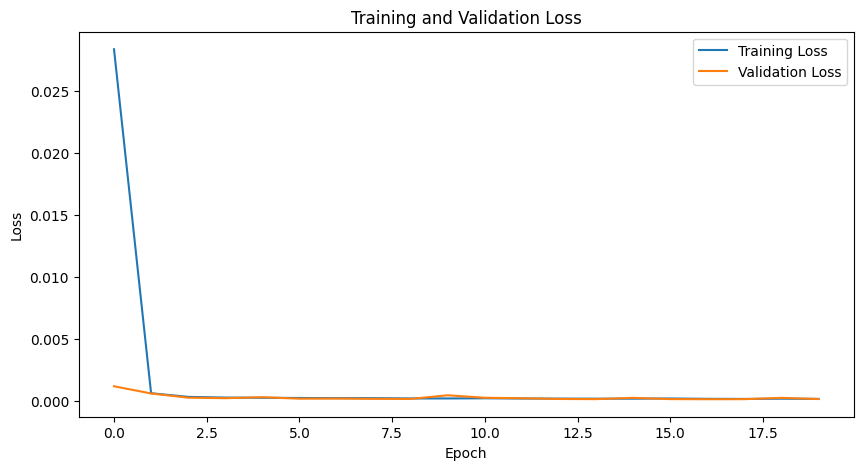

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(vali_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

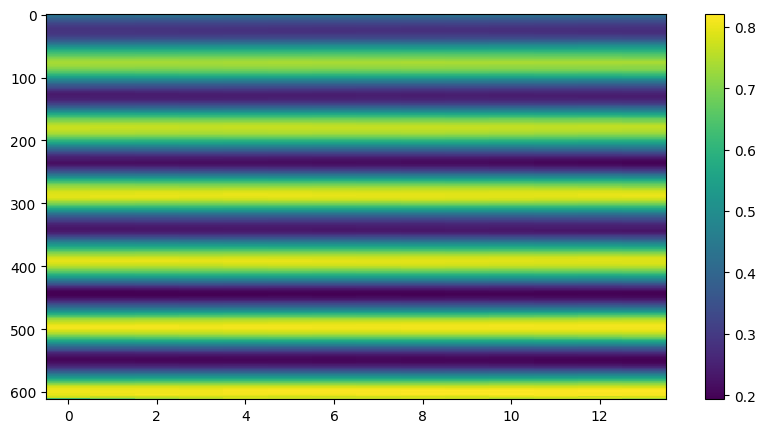

In [14]:
H_val_NN = H_NN_val.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

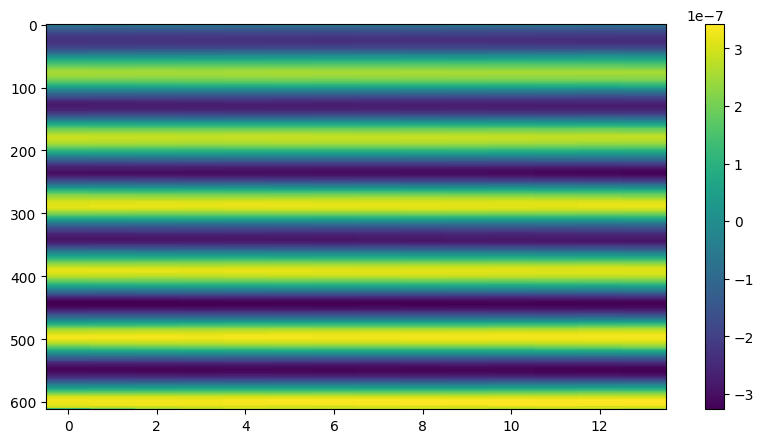

In [15]:
# De-normalized _ estimated channel (LS+linear interpolate + NN)
H_val_NN_denormd = H_NN_val * (H_true_train_max - H_true_train_min) + H_true_train_min
H_val_NN_denormd = H_val_NN_denormd.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

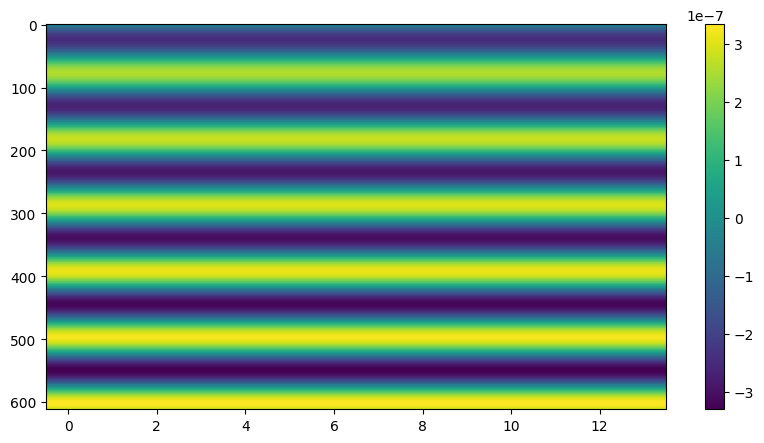

In [16]:
# True channel
H_val_true = H_true_val.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_true[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

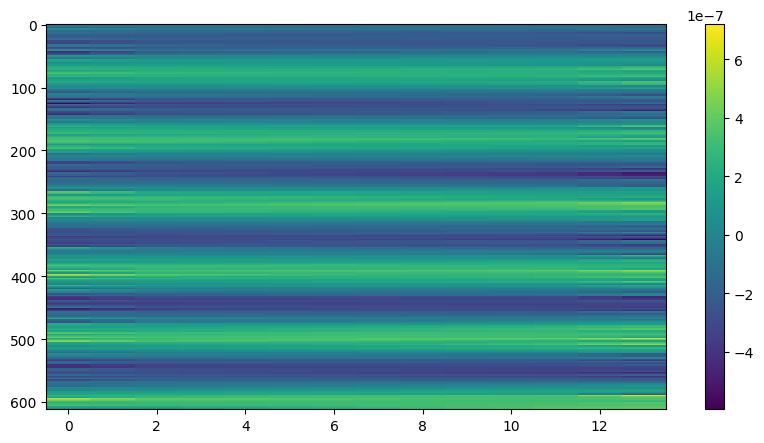

In [18]:
# Linear interpolated channel
H_linear_val = H_linear_val.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_linear_val[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [20]:
# convert to complex matrices
H_val_linInterp_complex = torch.complex(H_linear_val[:,0,:,:], H_linear_val[:,1,:,:])
H_val_NN_denormd_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])
H_val_true_complex = torch.complex(H_val_true[:,0,:,:], H_val_true[:,1,:,:])

In [21]:
# NMSE of Linear Interpolation
# Calculate the mean squared error
mse_LI = torch.mean(torch.abs(H_val_true_complex - H_val_linInterp_complex) ** 2)
# Calculate the variance of the reference tensor (complex_tensor1)
variance = torch.var(H_val_true_complex)
# Calculate the NMSE
nmse_LI = mse_LI / variance
print(f"NMSE: {nmse_LI.item()}")

NMSE: 0.08233936876058578


In [22]:
# NMSE of Linear Interpolation + NN
# Calculate the mean squared error
mse_LI_NN = torch.mean(torch.abs(H_val_true_complex - H_val_NN_denormd_complex) ** 2)
# Calculate the NMSE
nmse_LI_NN = mse_LI_NN / variance
print(f"NMSE: {nmse_LI_NN.item()}")

NMSE: 0.006069891154766083


When Input of the NN is just H_equalized

In [23]:
# Normalization
H_equal_train_min  = H_equal_train.min()
H_equal_train_max = H_equal_train.max()

H_equal_train_normd   = (H_equal_train - H_equal_train_min)/ (H_equal_train_max - H_equal_train_min)
H_equal_val_normd     = (H_equal_val - H_equal_train_min)/ (H_equal_train_max - H_equal_train_min)

In [24]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((H_equal_train_normd[:,0,:,:], H_equal_train_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)


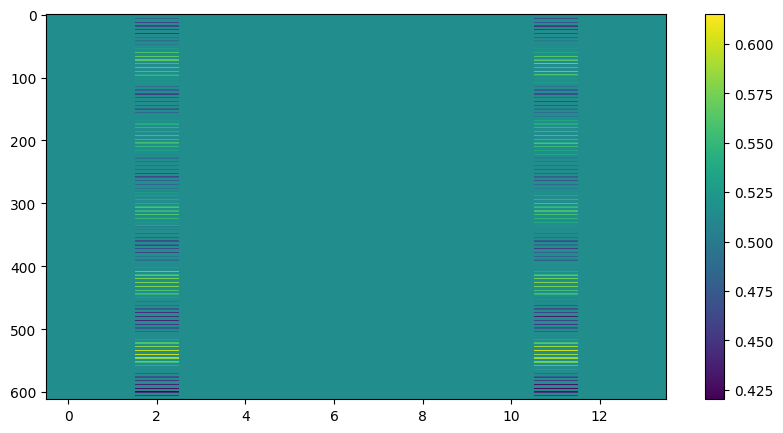

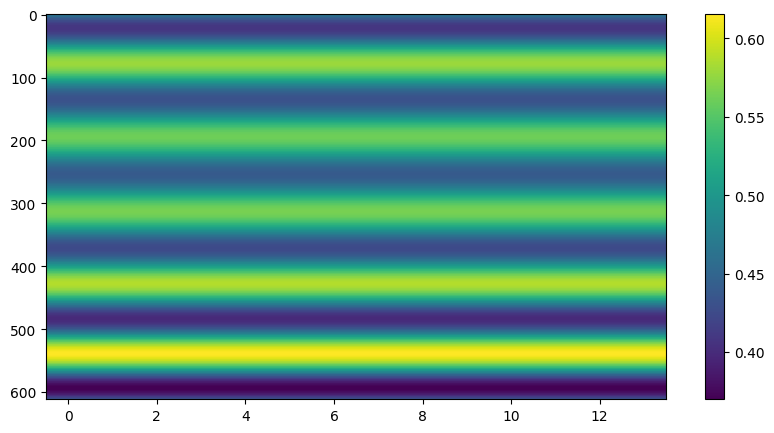

In [25]:
plot = 1
if plot:
    H_temp = trainData_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

    H_temp = trainLabels_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

In [40]:
# Create a DataLoader for your dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [nTrain, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(H_equal_val_normd, H_true_val_normd)  # [nVal, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [41]:
model2 = utils.CNN_Est().to(config.device)

In [42]:
train_loss, vali_loss, H_NN_val = config.train_loop(config.learning_rate, H_true_val, val_loader, train_loader, model2, config.NUM_EPOCHS)

Epoch 1/20, Loss: 0.032007651247113245 
 Val Loss: 0.0015224870294332504
Epoch 2/20, Loss: 0.0007281468742803554 
 Val Loss: 0.0006869029675726779
Epoch 3/20, Loss: 0.0004776329809980477 
 Val Loss: 0.0003701945715874899
Epoch 4/20, Loss: 0.0004066840498732442 
 Val Loss: 0.000340639402566012
Epoch 5/20, Loss: 0.00037183495426991914 
 Val Loss: 0.0003119758366665337
Epoch 6/20, Loss: 0.0003149778108308965 
 Val Loss: 0.0004619886094587855
Epoch 7/20, Loss: 0.000318475532822049 
 Val Loss: 0.00030389870395689894
Epoch 8/20, Loss: 0.000296164932630442 
 Val Loss: 0.00024313671989754462
Epoch 9/20, Loss: 0.00028427765929942933 
 Val Loss: 0.00026088669619639404
Epoch 10/20, Loss: 0.0002938490142696537 
 Val Loss: 0.0002510796014879209
Epoch 11/20, Loss: 0.00029542753433512797 
 Val Loss: 0.00024878286906944896
Epoch 12/20, Loss: 0.0002820261604483676 
 Val Loss: 0.00023573878388560843
Epoch 13/20, Loss: 0.0002847103110070748 
 Val Loss: 0.00022833793749062656
Epoch 14/20, Loss: 0.00027232

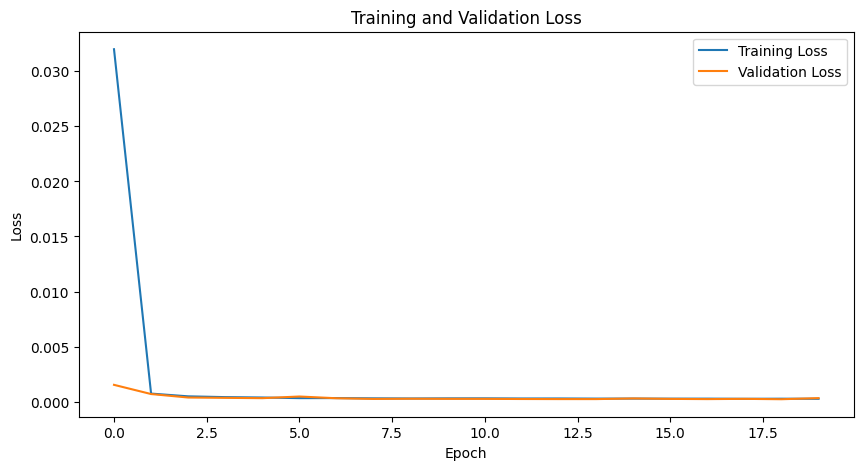

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(vali_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [45]:
H_val_NN_denormd = H_NN_val * (H_true_train_max - H_true_train_min) + H_true_train_min
H_val_NN_denormd = H_val_NN_denormd.cpu()

H_val_LS_NN_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])


In [46]:
# NMSE of LS + NN
# Calculate the mean squared error
mse_LS_NN = torch.mean(torch.abs(H_val_true_complex - H_val_LS_NN_complex) ** 2)
# Calculate the NMSE
nmse_LS_NN = mse_LS_NN / variance
print(f"NMSE: {nmse_LS_NN.item()}")

NMSE: 0.012085714377462864
